In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pyUSID as usid
import h5py

%matplotlib inline

In [2]:
data_dir = '../data'

## Analyze image data in h5 files to collect histograms

* The atoms have been found and separated into sub lattices using Stephen's method.


### Extract Mo and Re positions for each image

In [3]:
# select relevant atomic coordinates for further analysis
# different files store different atoms in centroids_1 and centroids_2 -> sort this out
names = ['re05', 're55', 're78', 're95'] # hdf5 file names
atom_pos = []
intensities = []

for name in names:
    h5_name = os.path.join(data_dir, name +'.h5')
    h5_file = h5py.File(h5_name, 'r+')
    
    atom_pos_grp= h5_file['Measurement_000']['Channel_000']['Atom_Positions']
    atom_centroids_1 = atom_pos_grp['Atom_Centroids_1']
    atom_centroids_2 = atom_pos_grp['Atom_Centroids_2']
    cropped_image = atom_pos_grp['Cropped_Image'][:]
    
    # metal atoms stored only in atom_centroids_1?
    if name in ['re05', 're55']:
        atoms = atom_centroids_1
    else:
        atoms = np.vstack((atom_centroids_1, atom_centroids_2))
        
    atom_pos.append(atoms)
    intensities.append(cropped_image)

In [4]:
# Separate atoms to Mo and Re based on image-specific intensity threshold
thresh = [0.80, 0.45, 0.45, 0.45] # intensity thresholds

# store types of atoms
atom_ids = []

for atoms, intensity, thrs in zip(atom_pos, intensities, thresh):
    
    ids = []
    for i in range(atoms.shape[0]):
        x, y = atoms[i,:]

        if intensity[int(x),int(y)] >= thrs:
            ids.append(1)
        else:
            ids.append(0)

    atom_ids.append(np.array(ids))

**Plot all images with indicated Mo and Re atoms**

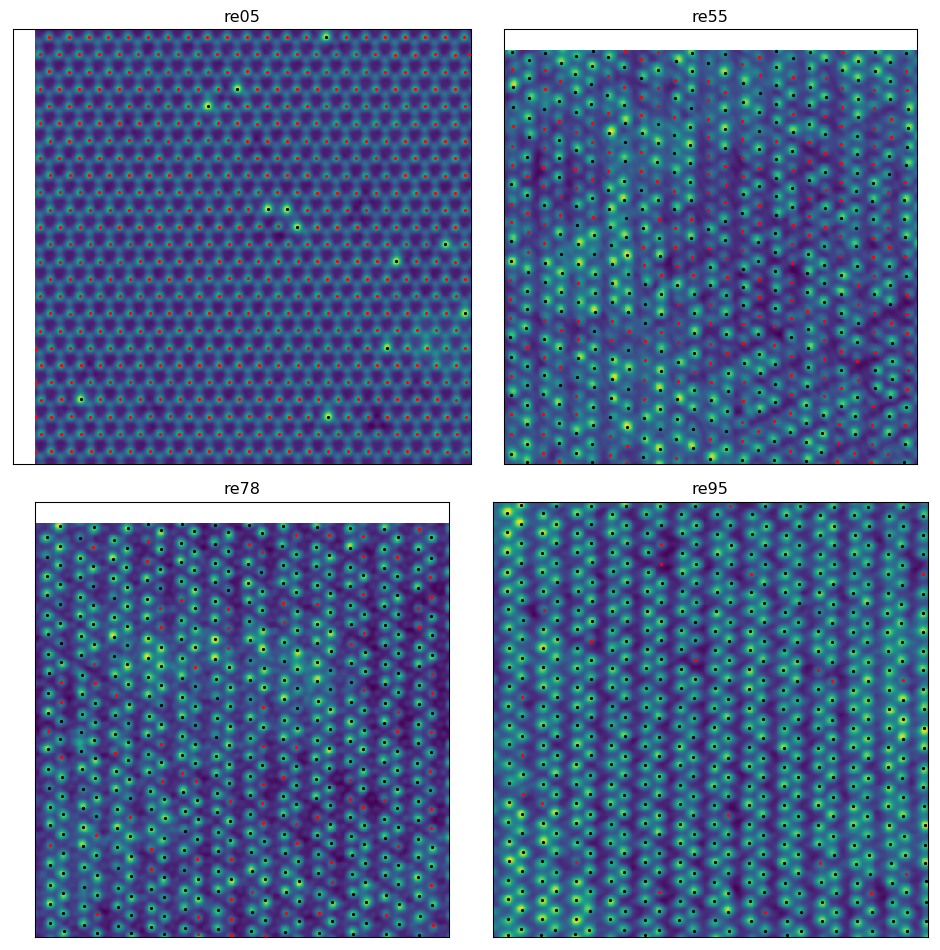

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), dpi = 96)

for i, (name, img, apos, aids) in enumerate(zip(names, intensities, atom_pos, atom_ids)):
    ir, ic = divmod(i, 2)
    axs[ir, ic].imshow(img)#, cmap = 'hot')
    axs[ir, ic].scatter(apos[aids==0,1], apos[aids==0,0], c = 'r', s = 2)
    axs[ir, ic].scatter(apos[aids==1,1], apos[aids==1,0], c = 'k', s = 2)
    axs[ir, ic].get_xaxis().set_visible(False)
    axs[ir, ic].get_yaxis().set_visible(False)
    axs[ir, ic].set_title(name)

plt.tight_layout()
plt.show()

**Function to calculate atom-atom distances**

In [6]:
def dist_calc(pt, pts):
    """Distance between a point 'pt' and a list of points 'pts'"""
    
    distances = []
    for ind in range(pts.shape[0]):
        distances.append((np.sqrt((pt[0] - pts[ind,0])**2 + (pt[1] - pts[ind,1])**2), ind))
    
    return distances

**Collect histograms of all possible configurations**

In [7]:
def hexagon(pos):
    """
    Scale neighbor positions so that they have the same distance from the center of mass.
    """
    
    com_x = sum([p[0] for p in pos])/len(pos)
    com_y = sum([p[1] for p in pos])/len(pos)
    
    pos_hex = []
    for i, p in enumerate(pos):
        dx = p[0] - com_x
        dy = p[1] - com_y
        r = (dx*dx + dy*dy)**0.5
        dx /= r
        dy /= r
        pos_hex.append([dx, dy])
    
    return pos_hex

In [8]:
def classify(pos, ids):
    """
    Assign unique identifiers to the neighbor configurations
    """
    
    # scale to make the neighbor hexagon more regular
    pos = hexagon(pos)
    
    # collect pair distances between neighbors and add the pair type (0, 1, 2)
    pair_list = []
    for i in range(len(pos)):
        for j in range(i+1, len(pos)):
            r = np.sqrt((pos[i][0]-pos[j][0])**2 + (pos[i][1]-pos[j][1])**2)
            pair_list.append((r, ids[i]+ids[j]))
    
    assert len(pair_list) == 15, "Wrong number of pair distances: {len(pair_list)}"
    
    # sort the list according to distances
    pair_list = sorted(pair_list, key=lambda x: x[0])
    
    # number of Re-Re pafirs among the 6 shortest distances distances (ortho)
    n_ortho = sum([1 for elem in pair_list[0:6] if elem[1] == 2])
    
    # number of Re-Re pafirs among the 6 medium distances distances (meta)
    n_meta = sum([1 for elem in pair_list[6:12] if elem[1] == 2])
    
    # number of Re-Re pafirs among the 3 longest distances distances (para)
    n_para = sum([1 for elem in pair_list[12:15] if elem[1] == 2])
    
    # numbef of Re atoms in the neighbor list
    n_atom = sum([1 for elem in ids if elem == 1])

    return [n_atom, n_ortho, n_meta, n_para]

In [9]:
from collections import Counter

# Image specific distance thresholds and window sizes
dist_thres = [45, 32, 30, 26]

histograms = []

# cycle over lists of atoms from different images
for name, apos, aids, dthres in zip(names, atom_pos, atom_ids, dist_thres):

    configs = []
    
    # for each atom, find its neighbors, center it
    for i, (c_pos, c_id) in enumerate(zip(apos, aids)):
        
        x, y = c_pos
        distances = dist_calc([x, y], apos)

        neighbor_i = []
        neighbor_pos = []
        neighbor_id = []
        for k in range(len(distances)):
            if distances[k][0] <= dthres and distances[k][0] > 0:
                j = distances[k][1]
                neighbor_i.append(j)
                neighbor_pos.append(apos[j])
                neighbor_id.append(aids[j])
        
        if len(neighbor_i) < 6:
            continue
            
        assert len(neighbor_i) == 6, f"Incorrect number of neighbors: {len(neighbor_i)}, {name}"
        
        # classify configurations - assign unique ids based on counts of ortho, meta, and para distances
        configs.append(tuple([c_id] + classify(neighbor_pos, neighbor_id)))
            
    # get counts of distinct configuraions
    counts = Counter(configs)
    print('Number of configuration types:', len(counts))
    print('Total number of configurations (atoms with 6 neighbors):', sum(counts.values()))#, counts)
    histograms.append(counts)  

Number of configuration types: 8
Total number of configurations (atoms with 6 neighbors): 464


KeyboardInterrupt: 

**Create a set of all dictinct configurations found in the four images**

In [ ]:
ks = []
for h in histograms:
    ks.extend(h.keys())

cfg_types = sorted(list(set(ks)))
print('Number of distinct configurations:', len(cfg_types))

**Plot configuration histograms for different images**

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), dpi = 96)

cfg_labels = [str(c) for c in cfg_types]
for i, (name, counts) in enumerate(zip(names, histograms)):
    all_counts = np.array([counts.get(cfg, 0) for cfg in cfg_types])
    n_sample = np.sum(all_counts)
    all_counts = all_counts/float(n_sample)

    ir, ic = divmod(i, 2)
    axs[ir, ic].bar(cfg_labels, all_counts)
    axs[ir, ic].set_xticklabels(cfg_labels, rotation=90.0)
    axs[ir, ic].set_title('Image: ' + name + ', Total number of samples: ' + str(n_sample))
    
plt.tight_layout()
plt.show()